In [1]:
import sys
import numpy as np
import torch.utils

sys.path.append(".")
sys.path.append("..")

import torch
import model
import train
import utils
from sklearn.svm import LinearSVC

# import evaluate
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

z_dim = 30
c_dim = [0, 2]
phi_hidden_size = 64
tau_hidden_size = 64
phi_num_layers = 2
tau_num_layers = 2
lr_max = 1
lr_min = 1e-3
mmcca_decay = 1e-1
weight_decay = 1e-4
batch_size1 = 100
batch_size2 = 1000
num_iters = 50
inner_epochs = 3
beta = 1
_lambda = 100

# Encoder and decoder network
ae_model = model.CNNDAE(z_dim, c_dim, channels=1).to(device)

/cis/home/skoukun1/miniconda3/envs/splice/lib/python3.11/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [3]:
ae_model.load_state_dict(torch.load("lyu_mnist_model.pth"))

<All keys matched successfully>

In [4]:
data = np.load(
        "/cis/home/skoukun1/projects/SPLICE/data/mnist/mnist_rotated_360.npz"
    )

X = torch.Tensor(data["original"][:50000]).to(device).reshape(-1, 1, 28, 28)
Y = torch.Tensor(data["rotated"][:50000]).to(device).reshape(-1, 1, 28, 28)

X_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)

In [5]:
shared, private, recons = ae_model([X, Y])

shared_1 = shared[0].detach().cpu().numpy()
shared_2 = shared[1].detach().cpu().numpy()

private = private[1].detach().cpu().numpy()
recon_orig = recons[0].detach().cpu().numpy().squeeze()
recon_rot = recons[1].detach().cpu().numpy().squeeze()

# X_test = X_test.cpu().numpy().squeeze()
# Y_test = Y_test.cpu().numpy().squeeze()

In [8]:
shared_test, private_test, recons_test = ae_model([X_test, Y_test])

shared_test_1 = shared_test[0].detach().cpu().numpy()
shared_test_2 = shared_test[1].detach().cpu().numpy()


In [18]:
svm = LinearSVC(max_iter=10000)
svm.fit(shared_test_2, data["labels"][60000:])
svm.score(shared_test_2, data["labels"][60000:])

0.7636

In [14]:
tsne = TSNE(n_components=2)
shared_tsne = tsne.fit_transform(shared_test_2)

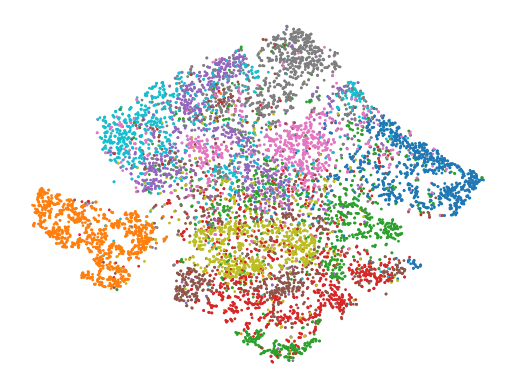

In [21]:
plt.scatter(shared_tsne[:, 0], shared_tsne[:, 1], c=data["labels"][60000:], cmap="tab10", s=1); plt.axis("off")
plt.savefig("../figures/arxiv_figures/Lyu_mnist360_tsne.png", dpi=300, transparent=True)


### look at CCA loss

In [ ]:
corr = np.corrcoef(shared_1.T, shared_2.T)

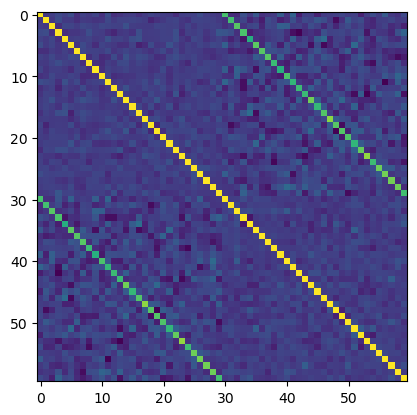

In [ ]:
plt.imshow(corr)

In [ ]:
np.trace(corr[:30,30:])/30

0.6645485814813041

### Single reconstruction

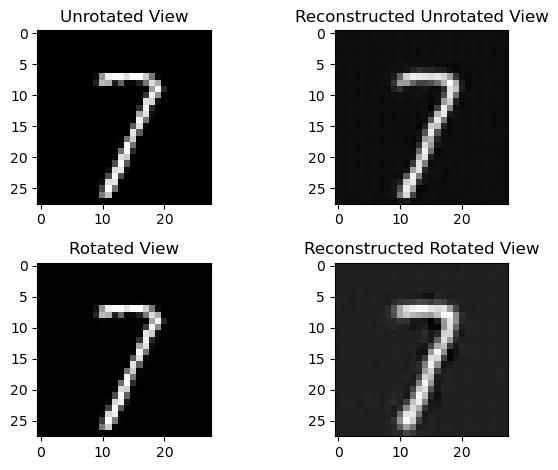

In [52]:
plt.subplot(2, 2, 1)
plt.imshow(X_test[1703], cmap="gray")
plt.title("Unrotated View")

plt.subplot(2, 2, 2)
plt.imshow(recon_orig[1703], cmap="gray")
plt.title("Reconstructed Unrotated View")

plt.subplot(2, 2, 3)
plt.imshow(Y_test[1703], cmap="gray")
plt.title("Rotated View")

plt.subplot(2, 2, 4)
plt.imshow(recon_rot[1703], cmap="gray")
plt.title("Reconstructed Rotated View")

plt.tight_layout()

# plt.imshow(recon_rot[0])
plt.savefig("../figures/arxiv_figures/Lyu_cross-recon_original_recon.svg", transparent=True, dpi=300)

### Plot privates

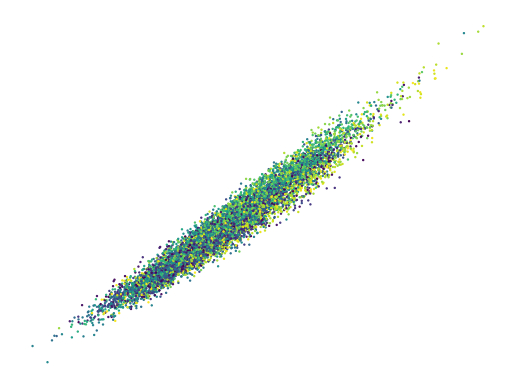

In [28]:
plt.scatter(private_test[1][:, 0].detach().cpu().numpy(), private_test[1][:, 1].detach().cpu().numpy(), s = 0.5, c=data["angles"][60000:]);
plt.axis("off")
plt.savefig("../figures/arxiv_figures/Lyu_mnist360_private.png", dpi=300, transparent=True)

### More example reconstructions

In [4]:
X_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)

shared, private, recons = ae_model([X_test, Y_test])

shared_1 = shared[0].detach().cpu().numpy()
shared_2 = shared[1].detach().cpu().numpy()

private = private[1].detach().cpu().numpy()
recon_orig = recons[0].detach().cpu().numpy().squeeze()
recon_rot = recons[1].detach().cpu().numpy().squeeze()

X_test = X_test.cpu().numpy().squeeze()
Y_test = Y_test.cpu().numpy().squeeze()

NameError: name 'data' is not defined

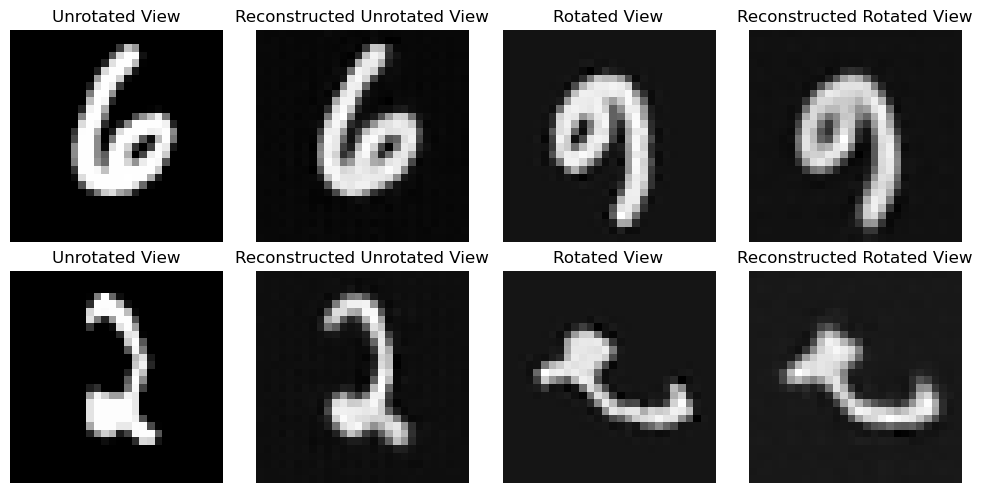

: 

In [24]:
plt.figure(figsize=(10, 5))

ind1 = np.random.choice(10000)
ind2 = np.random.choice(10000)

plt.subplot(2, 4, 1)
plt.imshow(X_test[ind1], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(recon_orig[ind1], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.imshow(Y_test[ind1], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(recon_rot[ind1], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(X_test[ind2], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.imshow(recon_orig[ind2], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.imshow(Y_test[ind2], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.imshow(recon_rot[ind2], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.tight_layout()

plt.savefig("../figures/arxiv_figures/Lyu_reconstructions.svg", transparent=True, dpi=300)

### Cross reconstruction

In [11]:
digit_source = (torch.Tensor(torch.tile(X_test[2463], [5,1])).to(device)).reshape(-1, 1, 28, 28)
rot_angles = [36, 108, 180, 252, 324]
# rot_inds = [2275, 7010, 1738, 5589, 4232]
rot_inds = [264, 3910, 2463, 4756, 7293]
# angle_sources = []
angle_sources = np.zeros((5,784))


for i, angle in enumerate(rot_angles):
    angle_sources[i] = rot_digit(data["original"][-10000:][rot_inds[i]], angle=angle)[0]


# for i, angle in enumerate(rot_angles):
# #     angle_sources[i] = Y_test[rot_inds[i]].cpu().numpy()

# for angle in rot_angles:
#     ind = 0
#     argsort = np.argsort(np.abs(data["angles"][-10000:] -angle))
#     while data["labels"][-10000:][argsort[ind]] == 5:
#         ind += 1

#     angle_sources.append(argsort[ind])
angle_sources = torch.Tensor(angle_sources).to(device).reshape(-1, 1, 28, 28)


torch.Size([5, 1, 28, 28])

In [20]:
priva.shape

torch.Size([5, 30])

In [21]:
X_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)

# shared, private, recons = ae_model([X_test, Y_test])
shared, _ = ae_model.encoder[1](digit_source)
_, private = ae_model.encoder[1](angle_sources)



cross_recon = ae_model.decoder[1](shared, private).squeeze().detach().cpu().numpy()

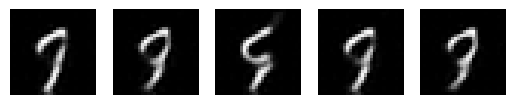

In [22]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cross_recon[i].reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")

plt.savefig("../figures/arxiv_figures/Lyu_cross_recon.svg", transparent=True, dpi=300)

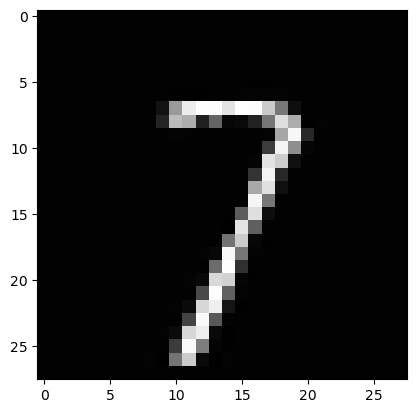

In [55]:
plt.imshow(Y_test[1703].detach().cpu().numpy().squeeze(), cmap="gray")
plt.savefig("../figures/arxiv_figures/Lyu_cross-recon_original-digit.svg", transparent=True, dpi=300)

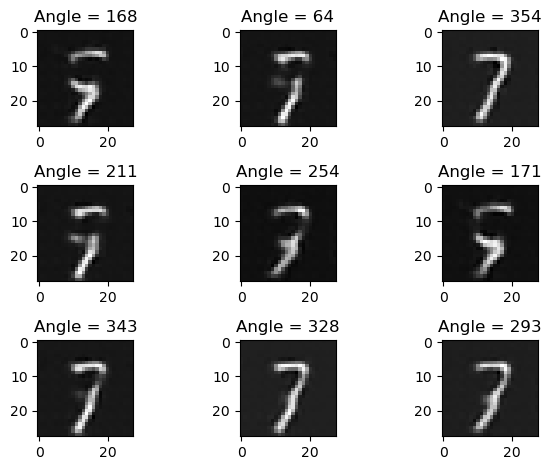

In [57]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cross_recon[np.random.choice(10000)], cmap='gray')
    plt.title("Angle = %d" % (data["angles"][60000:][i]))

plt.tight_layout()
plt.savefig("../figures/arxiv_figures/Lyu_cross-recon.svg", transparent=True, dpi=300)

### Align and calculate variance given theta

In [12]:
private = private[1].detach().cpu().numpy()

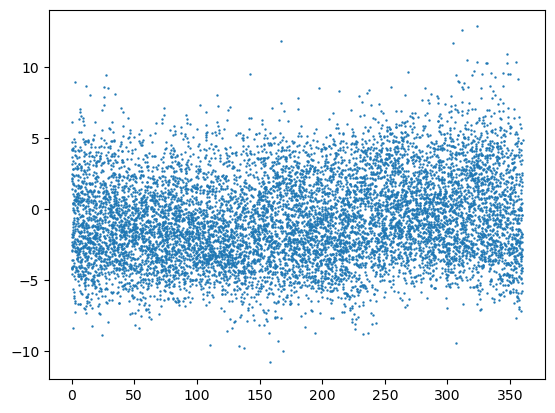

In [13]:
plt.scatter(data["angles"][60000:], private[:, 0], s = 0.5)

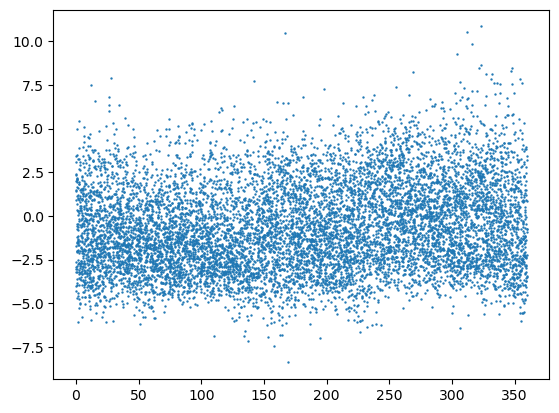

In [14]:
plt.scatter(data["angles"][60000:], private[:, 1], s = 0.5)

In [6]:
def rot_digit(m, angle=-1):
    """
    Returns the digit/image "m" by a random angle [-45,45]deg
    clips it to MNIST size
    and returns it flattened into (28*28,) shape
    """
    if angle < 0:
        angle=np.random.rand()*360 #will lead to ambiguities because "6" = "9"

    m = m.reshape((28,28))
    tmp = rotate(m, angle=angle)
    xs, ys = tmp.shape
    xs = int(xs/2)
    ys = int(ys/2)
    rot_m = tmp[xs-14:xs+14,ys-14:ys+14]
    return rot_m.reshape((28*28,)), angle

In [18]:
X_test = X_test.detach().cpu().numpy().squeeze()

In [32]:
base_rot = np.zeros((360, 28*28))

for i in range(360):
    base_rot[i] = rot_digit(X_test[-10000:][0], angle=i)[0]

base_rot = torch.Tensor(base_rot/255).to(device)

base_rot[base_rot > 1] = 1
base_rot[base_rot < 0] = 0

shared, private = ae_model.encoder[1](base_rot.reshape(-1, 1, 28, 28))
private = private.detach().cpu().numpy()

In [34]:
def find_offset(digit, reference, model):
    rot = np.zeros((360, 28*28))

    for i in range(360):
        rot[i] = rot_digit(digit, angle=i)[0]

    rot = torch.Tensor(rot/255).to(device)
    rot[rot > 1] = 1
    rot[rot < 0] = 0

    shared, private = model.encoder[1](rot.reshape(-1, 1, 28, 28))
    private = private.detach().cpu().numpy()

    coarse_shift = np.arange(0, 360, 20)
    inner_prods = np.zeros_like(coarse_shift)

    for i, shift in enumerate(coarse_shift):
        shifted = np.roll(private[:,0], shift)
        inner_prods[i] = np.dot(shifted, reference)

    best_coarse = coarse_shift[np.argmax(inner_prods)]

    fine_shift = np.arange(best_coarse-10, best_coarse+10)
    inner_prods = np.zeros_like(fine_shift)

    for i, shift in enumerate(fine_shift):
        shifted = np.roll(private[:,0], shift)
        inner_prods[i] = np.dot(shifted, reference)

    best_fine = fine_shift[np.argmax(inner_prods)]

    return best_fine
    

In [35]:
shifts = np.zeros(5000)

for i in range(5000):
    print(i, end="\r")
    shifts[i] = find_offset(X_test[-10000:][i], private[:,0], ae_model)

In [36]:
shared, private = ae_model.encoder[1](Y_test[:5000].reshape(-1, 1, 28, 28))
private = private.detach().cpu().numpy()

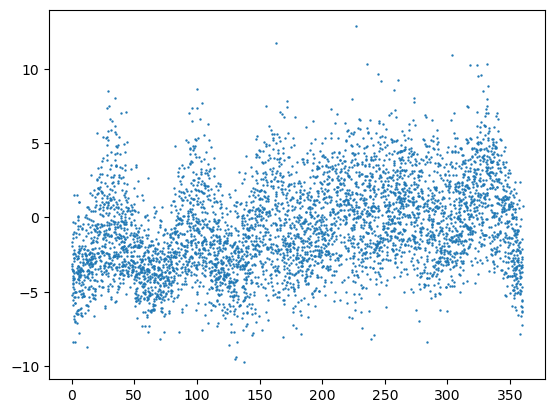

In [44]:
plt.scatter((data["angles"][60000:][:5000] + shifts)%360, private[:, 0], s = 0.5)
plt.savefig("../figures/arxiv_figures/aligned_latent0_vs_theta.png", transparent=True, dpi=300)

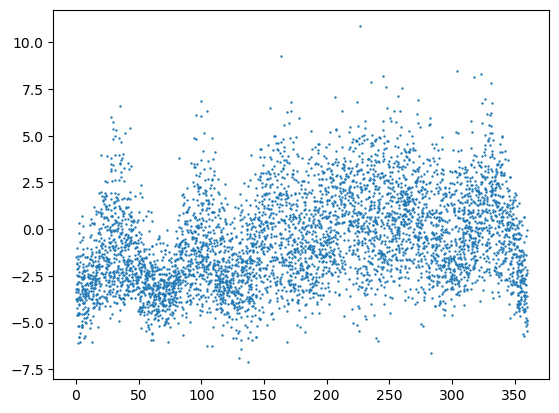

In [45]:
plt.scatter((data["angles"][60000:][:5000]+ shifts)%360, private[:, 1], s = 0.5)
plt.savefig("../figures/arxiv_figures/aligned_latent1_vs_theta.png", transparent=True, dpi=300)

In [47]:
window_vars = []

shifted_angles = (data["angles"][-10000:][:5000]+shifts) % 360
full_var = np.var(private[:5000], axis=0)
width = 5

for i in range(360):
    window = private[:5000][(shifted_angles > i) & (shifted_angles < i+width)]
    var = np.var(window, axis=0)/full_var
    window_vars.append(var.mean())

In [48]:
np.array(window_vars).mean()

0.71595377